In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
import torch
import ast

In [57]:
# Specify the path to your CSV file
csv_file_path = 'processed_output_data.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Define a function to safely evaluate and convert strings to Python objects
safe_eval = lambda x: ast.literal_eval(x) if pd.notnull(x) else x

# Columns to be converted to Python objects
columns_to_convert = ['llama_extracted_cause_effect_pairs', 'gpt_extracted_cause_effect_pairs', 'llama_text_list', 'gpt_text_list']
df[columns_to_convert] = df[columns_to_convert].applymap(safe_eval)
assert isinstance(df['gpt_text_list'][0], list)
assert isinstance(df['llama_extracted_cause_effect_pairs'][0], dict)
df.head(2)


,id,date_publish,outlet,headline,lead,body,authors,domain,url,political_leaning,n_words,n_tokens,GPT_causal_graph,formatted_prompt,decoded_output,llama_extracted_cause_effect_pairs,gpt_extracted_cause_effect_pairs,llama_text_list,gpt_text_list,blue_score
0,18334433,2018-01-02 12:03:40,BBC,Is parent power driving grammar school expansion?,"Grammars have been growing, with more than 7,5...",Image caption Ruth Cornish wants an academical...,Branwen Jeffreys;Education Editor,www.bbc.com,http://www.bbc.com/news/education-42416365,UNDEFINED,1012,1271,1. [cause] Ruth Cornish's desire for an academ...,### Instruction: Below is an excerpt from a ne...,<s> ### Instruction: Below is an excerpt from ...,{'Mother starting to consider selecting school...,{'Ruth Cornish's desire for an academically se...,[[cause] Mother starting to consider selecting...,[[cause] Ruth Cornish's desire for an academic...,0.699039
1,38951552,2018-01-02 10:56:28,The Guardian,UK manufacturing growth stays strong at end of...,Sector has best three months for growth since ...,Sector has best three months for growth since ...,Richard Partington,www.theguardian.com,https://www.theguardian.com/business/2018/jan/...,LEFT,347,430,1. [cause] Strongest three months for growth s...,### Instruction: Below is an excerpt from a ne...,<s> ### Instruction: Below is an excerpt from ...,{'Stronger than usual growth in global markets...,{'Strongest three months for growth since 2014...,[[cause] Stronger than usual growth in global ...,[[cause] Strongest three months for growth sin...,0.776408


In [86]:
# Load the sentence transformer model for embedding generation
model = SentenceTransformer('all-mpnet-base-v2');

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

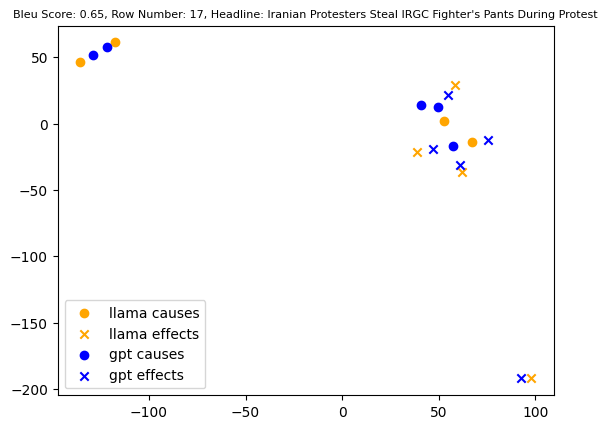

In [97]:
import matplotlib.pyplot as plt

#get a list of indices decrease sorted by bleu score
indices = np.array(df['blue_score'].argsort()[::-1])

# Find the row with highest bleu score
row = df.iloc[indices[80]]

# convert all causes and effects to embeddings, 
#and visualize them using PCA, with orange dots denoting the causes from llama, and blue dots denoting the causes from gpt
#the same for effects, except the shape is a triangle
#NOTE: the llama_extracted_cause_effect_pairs is a dictionary, with causes being keys and effects being values
#convert causes to embeddings
llama_pairs = row['llama_extracted_cause_effect_pairs']
causes = list(llama_pairs.keys())
causes_embeddings = model.encode(causes)
causes_embeddings = np.array(causes_embeddings)

#convert effects to embeddings
effects = list(llama_pairs.values())
effects_embeddings = model.encode(effects)
effects_embeddings = np.array(effects_embeddings)

#convert causes to embeddings
gpt_pairs = row['gpt_extracted_cause_effect_pairs']
causes_gpt = list(gpt_pairs.keys())
causes_embeddings_gpt = model.encode(causes_gpt)
causes_embeddings_gpt = np.array(causes_embeddings_gpt)

#convert effects to embeddings
effects_gpt = list(gpt_pairs.values())
effects_embeddings_gpt = model.encode(effects_gpt)
effects_embeddings_gpt = np.array(effects_embeddings_gpt)

In [ ]:

#combine all embeddings and feed into TSNE, and then unpack them into 4 separate arrays, and visualize
tsne = TSNE(n_components=2, perplexity=1, random_state=0)
embeddings = np.concatenate((causes_embeddings, effects_embeddings, causes_embeddings_gpt, effects_embeddings_gpt), axis=0)
embeddings = tsne.fit_transform(embeddings)
causes_embeddings = embeddings[:len(causes_embeddings)]
effects_embeddings = embeddings[len(causes_embeddings):len(causes_embeddings)+len(effects_embeddings)]
causes_embeddings_gpt = embeddings[len(causes_embeddings)+len(effects_embeddings):len(causes_embeddings)+len(effects_embeddings)+len(causes_embeddings_gpt)]
effects_embeddings_gpt = embeddings[len(causes_embeddings)+len(effects_embeddings)+len(causes_embeddings_gpt):]

In [ ]:
#visualize both the cause and effect embeddings and labels, legends, titled the bleu score (2 decimals) and row number, and headline, with smaller font
plt.scatter(causes_embeddings[:,0], causes_embeddings[:,1], c='orange', label='llama causes')
plt.scatter(effects_embeddings[:,0], effects_embeddings[:,1], c='orange', marker='x', label='llama effects')
plt.scatter(causes_embeddings_gpt[:,0], causes_embeddings_gpt[:,1], c='blue', label='gpt causes')
plt.scatter(effects_embeddings_gpt[:,0], effects_embeddings_gpt[:,1], c='blue', marker='x', label='gpt effects')
plt.title('Bleu Score: ' + str(round(row['blue_score'], 2)) + ', Row Number: ' + str(row.name) + ', Headline: ' + row['headline'], fontsize=8)
plt.legend()
plt.show()

In [151]:
#get all llama causes and effects for all rows, handle nan values
causes_all = []
effects_all = []
for index, row in df.iterrows():
    llama_pairs = row['llama_extracted_cause_effect_pairs']
    if isinstance(llama_pairs, float):
        continue
    causes = list(llama_pairs.keys())
    effects = list(llama_pairs.values())
    causes_all.extend(causes)
    effects_all.extend(effects)

#generate embeddings for all llama causes and effects
causes_embeddings_all = model.encode(causes_all)
causes_embeddings_all = np.array(causes_embeddings_all)
effects_embeddings_all = model.encode(effects_all)
effects_embeddings_all = np.array(effects_embeddings_all)

In [152]:
all_items = causes_all + effects_all
all_embeddings = np.concatenate((causes_embeddings_all, effects_embeddings_all), axis=0)

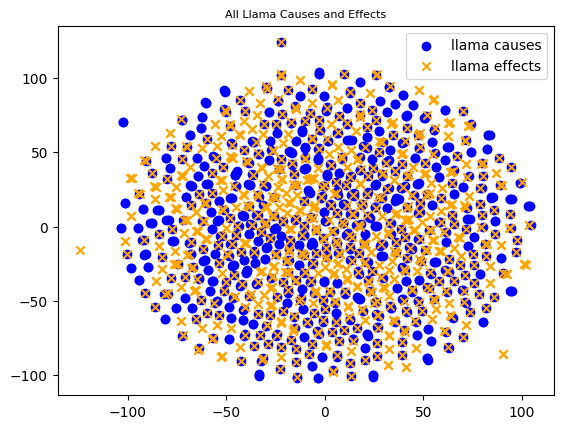

In [122]:
#visualize all llama causes and effects
tsne = TSNE(n_components=2, perplexity=1, random_state=0)
embeddings = np.concatenate((causes_embeddings_all, effects_embeddings_all), axis=0)
embeddings_2d = tsne.fit_transform(embeddings)
causes_embeddings_all = embeddings[:len(causes_embeddings_all)]
effects_embeddings_all = embeddings[len(causes_embeddings_all):]

#plot
plt.scatter(causes_embeddings_all[:,0], causes_embeddings_all[:,1], c='blue', label='llama causes')
plt.scatter(effects_embeddings_all[:,0], effects_embeddings_all[:,1], c='orange', marker='x', label='llama effects')
plt.title('All Llama Causes and Effects', fontsize=8)
plt.legend()
plt.show()

In [153]:
#for the embeddings, compute the similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(all_embeddings)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


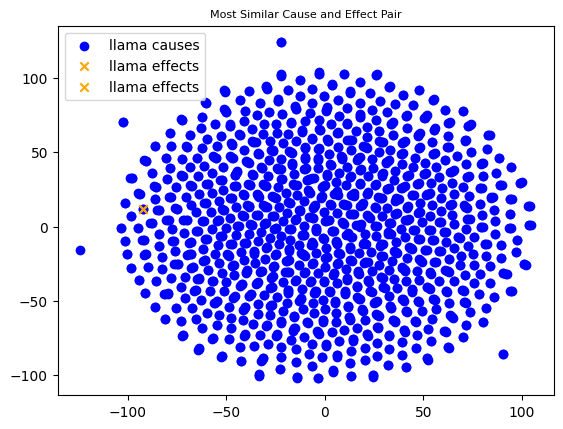

In [179]:
#list top 5 similarity scores from the similarity matrix
#sort the similarity matrix in descending order, except the diagonal

#set the diagonal to nan
np.fill_diagonal(similarity_matrix, -1000)

#sort the similarity matrix in descending order
sorted_similarity_matrix = np.sort(similarity_matrix, axis=None)[::-1]
#find the top 10 similarity scores
top_10_similarity_scores = sorted_similarity_matrix[:10]
print('Top 10 similarity scores: ' + str(top_10_similarity_scores))


Top 10 similarity scores: [0.9999999  0.9999999  0.99807966 0.99807966 0.98924005 0.98924005
 0.9878847  0.9878847  0.9857888  0.9857888 ]


In [191]:
# Specify the file path for the output text file
output_file_path = 'similarity_examples.txt'

# Open the file in write mode
with open(output_file_path, 'w') as file:
    # Find the most similar cause and effect pair
    # Find the row and column where similarity matrix is the third highest
    for top in range(0, 200, 2):
        max_row = np.where(similarity_matrix == sorted_similarity_matrix[top])[0][0]
        max_col = np.where(similarity_matrix == sorted_similarity_matrix[top])[1][0]
        # Find the indices of the most similar items
        max_indices = [max_row, max_col]
        # Find the most similar items
        max_items = [all_items[i] for i in max_indices]
        # Write the output strings to the file
        file.write('Rank: ' + str(top // 2) + '\n')
        file.write('Most similar items: ' + str(max_items) + '\n')
        file.write('The cosine similarity score is: ' + str(sorted_similarity_matrix[top]) + '\n')
        file.write("-" * 50 + '\n')

# Print a message indicating that the output has been written to the file
print('The output has been written to the file: ' + output_file_path)


The output has been written to the file: similarity_examples.txt
